In [3]:
from ultralytics import YOLO
from utils.extract_fields import extract_fields
from utils.draw_bounding_boxes import draw_bounding_box
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

In [4]:
from detector import FieldDetector

In [7]:
FIELD_MODEL_PATH = 'best.pt'
#FIELD_MODEL_PATH = 'field_model_v2.1_based_on_CCCDYolo.pt'

In [8]:
field_detector = FieldDetector(FIELD_MODEL_PATH, verbose=True)

Model summary: 209 layers, 43,636,779 parameters, 0 gradients, 165.4 GFLOPs


In [5]:
metrics = field_detector.evaluate('./data.yaml')
print(f'\nPrecision: {metrics['mean_precision']}')
print(f'Recall: {metrics['mean_recall']}')
print(f'mAP50: {metrics['mean_mAP50']}')
print(f'mAP50-95: {metrics['mean_mAP50-95']}')

Ultralytics 8.3.86  Python-3.12.6 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce GTX 1070, 8192MiB)
Model summary (fused): 112 layers, 43,613,547 parameters, 0 gradients, 164.9 GFLOPs


val: Scanning F:\CV_Project\src\modules\fields_recognition\dataset_v2.1\valid\labels.cache... 226 images, 14 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


                   all        240       1880      0.899      0.939      0.944      0.878
                    id        201        202      0.854       0.98      0.956      0.888
             full_name        209        219      0.894      0.927      0.944      0.902
         date_of_birth        197        197      0.937      0.911      0.949      0.903
                   sex        182        182      0.937      0.983      0.962       0.91
           nationality        219        243      0.854      0.852      0.917      0.834
       place_of_origin        179        203      0.875      0.897      0.929      0.804
    place_of_residence        167        289      0.878      0.921      0.913      0.793
        date_of_expiry        172        173      0.924       0.98       0.96       0.91
               qr_code        172        172      0.936          1      0.962      0.956
Speed: 0.6ms preprocess, 24.8ms inference, 0.0ms loss, 7.2ms postprocess per image
Results saved to runs\detec

In [38]:
#image_test_path = '235.png'
image_test_path = './identity-card/fc035e37928549bcb17538f02d19d5b3.png'
image_test = cv2.imread(image_test_path)


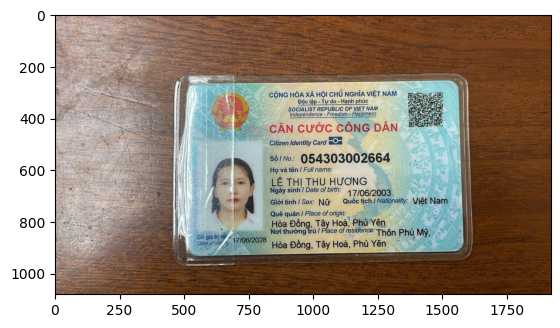

In [39]:
plt.imshow(image_test[:,:,::-1])
plt.show()

In [40]:
results = field_detector.predict(image_test)

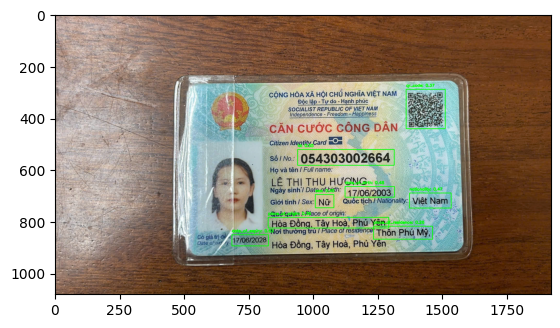

In [41]:
drawed_img = draw_bounding_box(results[0], image_test, field_detector)
plt.imshow(drawed_img[:,:,::-1]) 

In [30]:
class_names = [
    'id', 
    'full_name', 
    'date_of_birth', 
    'sex', 
    'nationality',
    'place_of_origin',
    'place_of_residence',
    'date_of_expiry',
    'qr_code']
#fields_per_class, found_classes = extract_fields(results[0].boxes, image_test)

In [31]:
def extract_fields(boxes, img):
    NUM_CLASSES = 9  # total number of classes
    fields_per_class = [[] for _ in range(NUM_CLASSES)]  # initialize list of lists
    box_list = []

    for idx_box, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # convert box coordinates to int
        confidence = box.conf[0].item()         # confidence score
        class_id = int(box.cls[0])              # class label

        cropped_object = img[y1:y2, x1:x2]

        if cropped_object.size == 0:
            print(f"Warning: Empty crop at box {idx_box} in result")
            continue

        box_list.append({
            'class_id': class_id,
            'confidence': confidence,
            'box': (x1, y1, x2, y2),
            'cropped': cropped_object
        })

    # Sort by y1 (top to bottom), then x1 (left to right)
    box_list.sort(key=lambda b: (b['box'][1], b['box'][0]))
    
    found_classes = list(map(lambda item: item['class_id'], box_list))
    fields = list(map(lambda item: item['cropped'], box_list))

    # Collect all crops for each class_id (accept duplicates)
    #for item in box_list:
    #    class_id = item['class_id']
    #    fields_per_class[class_id].append(item['cropped'])
    #
    # Find which classes were found (non-empty lists)
    #found_classes = [i for i, crops in enumerate(fields_per_class) if crops]

    return fields, found_classes

fields, found_classes = extract_fields(results[0].boxes, image_test)

In [32]:
import matplotlib.pyplot as plt

def show_fields(fields, class_names):
    plt.figure(figsize=(12, 8))

    for idx, (field, name) in enumerate(zip(fields, class_names)):
        plt.subplot(3, 4, idx + 1)

        if field is not None:
            # Kiểm tra shape của ảnh
            if len(field.shape) == 3:
                plt.imshow(field[:, :, ::-1])  # Color image (BGR -> RGB)
            else:
                plt.imshow(field, cmap='gray')  # Grayscale image

            plt.title(name)
        else:
            plt.title(f"{name} (missing)")

        plt.axis('off')

    plt.tight_layout()
    plt.show()


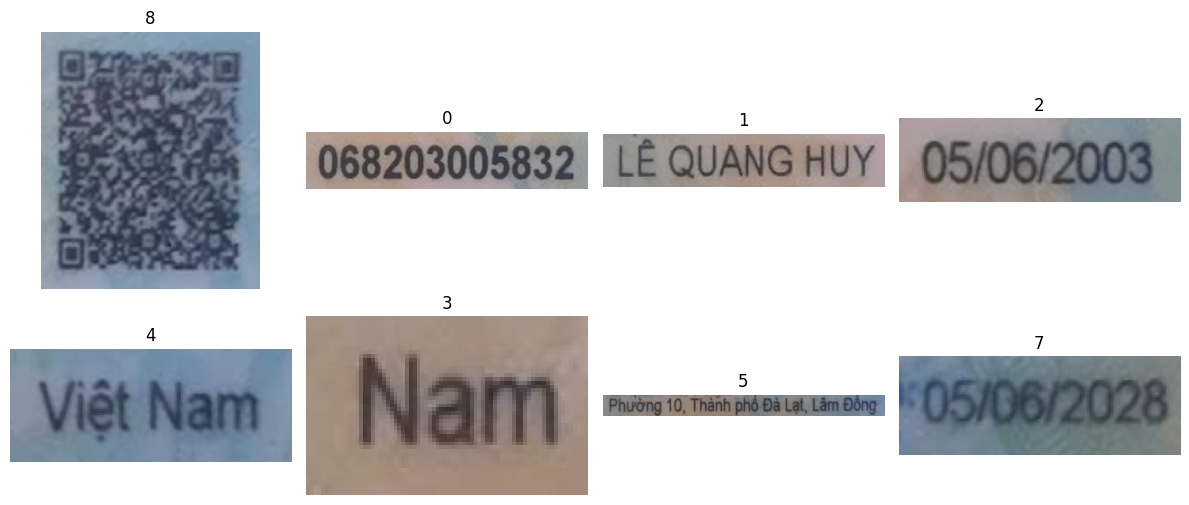

In [33]:
show_fields(fields, found_classes)